In [6]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline
from game import game, random_connection_game

In [7]:
import time
from IPython.display import clear_output

In [8]:
def randomAgent(state, Memb = 25):
    #move = random.randint(3)
    spin_1 = random.randint(Memb)
    spin_2 = random.randint(4)
    return (0, spin_1, spin_2)

In [9]:
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

In [10]:
Memb = 4*4

env = random_connection_game(9,  Memb, 
                             max_consecutive_failures = 50)

In [12]:
state = env.reset()
print(env.H.shape, env.Hemb.shape, env.Hmask.shape,
      env.state.shape)

(6, 6) (16, 16) (16, 16) (2, 16, 16)


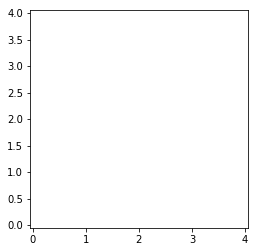

In [13]:
fig, ax = env.plot()


In [15]:
score = 0

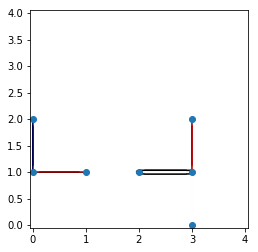

In [33]:
action = (0, 4, 0) # randomAgent(state, Memb)
state, reward, done =env.step(action)
score += reward

fig, ax = env.plot()


In [46]:
env.nS

8

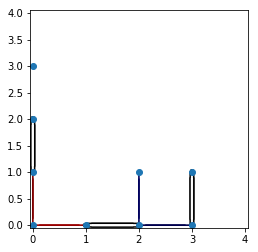

-0.4999999999999996 9 6 6 (0, 9, 1) 18


In [37]:
# Reset!
Memb = 16

env = random_connection_game(9,  Memb, 
                             max_consecutive_failures = 50)

state = env.reset()
fig, ax = env.plot()
score = 0.0
actions = []
for j in range(20):
    clear_output(wait=True)

    action = randomAgent(state, Memb)
    state, reward, done =env.step(action)
    score += reward
    actions.append((*action, reward))

    fig, ax = env.plot()
    plt.show()
    print(score, env.N, env.N0,env.nS,action, env.terms_left)
    if done >0:
        break